In [2]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gp
import shapely
import copy
import random
import acs_regionalization as ACS
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,20  #set the default map size
#rcParams['patch.linewidth'] = 0.5  #set default polygon line width

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print all output, not just last

C:\Users\JollyKD\AppData\Local\Continuum\anaconda2\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


(-94.07652734999999, -92.66785964999998, 44.423966549999996, 45.46198044999999)

[]

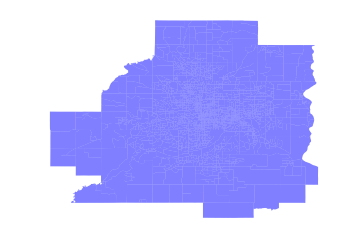

In [3]:
# read in the Ramsey shapefile and plot it   
shp_map = gp.read_file('metc_data/target/bg_metc.shp')
shp_map['constant'] = 1
p = shp_map.plot('constant', alpha=0.5, cmap='winter')
p.axis('off')
p.plot()

In [6]:
# read spatial data into python and run some diagnostics
w = ps.rook_from_shapefile('metc_data/target/bg_metc.shp', idVariable='GEOID')
print w.n   # number of block groups = 2085

2085


<BarContainer object of 18 artists>

Text(0.5,0,'number of neighbors')

Text(0,0.5,'number of block groups')

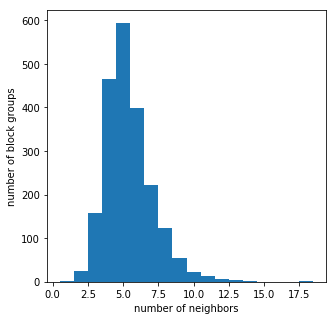

In [7]:
# summary of the connectivity structure of the Ramsey block groups
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of block groups')
# shows, for example, that ~600 block groups have 5 neighbors

In [8]:
# read in list of census tracts to exclude
exclude = open('metc_data/target/exclude.csv')
exclude = exclude.readline()
exclude = exclude.replace('g','')
exclude = exclude.split(',')
print exclude

['271230408021', '271630708011', '271630708021', '271239800001']


In [3]:
# read in the ACS estimates and standard errors
population = pd.read_csv('metc_data/target/target_population.csv', index_col=0)

population.shape
population.head

est_prop = pd.read_csv('metc_data/target/target_estimates_metc.csv', index_col=0)
moe_prop = pd.read_csv('metc_data/target/target_moe_metc.csv', index_col=0)


(2001, 1)

<bound method DataFrame.head of               totalppl
id                    
270030501091      1735
270030501092      1124
270030501093      1128
270030501094      1293
270030501101      1306
270030501102      1347
270030501111      1553
270030501112      1800
270030501113       447
270030502081      1621
270030502082      1730
270030502101      1122
270030502102      1150
270030502103       883
270030502104       854
270030502191      1292
270030502192      1661
270030502201      2238
270030502202      1645
270030502203      1260
270030502204      1926
270030502211      2055
270030502212      1279
270030502213      3941
270030502221      1328
270030502222      1052
270030502223      1330
270030502224      1733
270030502231      2874
270030502241       802
...                ...
271630710133      1509
271630710141      2739
271630710142      1433
271630710151      2013
271630710152      2365
271630710153      2394
271630710161      1904
271630710162      2700
271630710171      8111
27

In [13]:
# EXCLUDE PLACES WITH ZERO POPULATION

shp = ps.open('metc_data/target/bg_metc.shp')
random.seed(789)     # to ensure we get the same solution each time
np.random.seed(789)  # to ensure we get the same solution each time
results = ACS.ACS_Regions(w=w,\
                          target_est_prop=est_prop.values,\
                          target_moe_prop=moe_prop.values,\
                          count_est=population.values,\
                          target_th_all=0.10,\
                          exclude=exclude,\
                          compactness=shp,\
                          cv_exclude_prop=0.05)
print 'regionalization finished'

regionalization finished


In [15]:
print 'number of regions:', len(results.regions)
print 'total time (seconds):', results.time['total']

number of regions: 167
total time (seconds): 2293.6730001


C:\Users\JollyKD\AppData\Local\Continuum\anaconda2\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
C:\Users\JollyKD\AppData\Local\Continuum\anaconda2\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


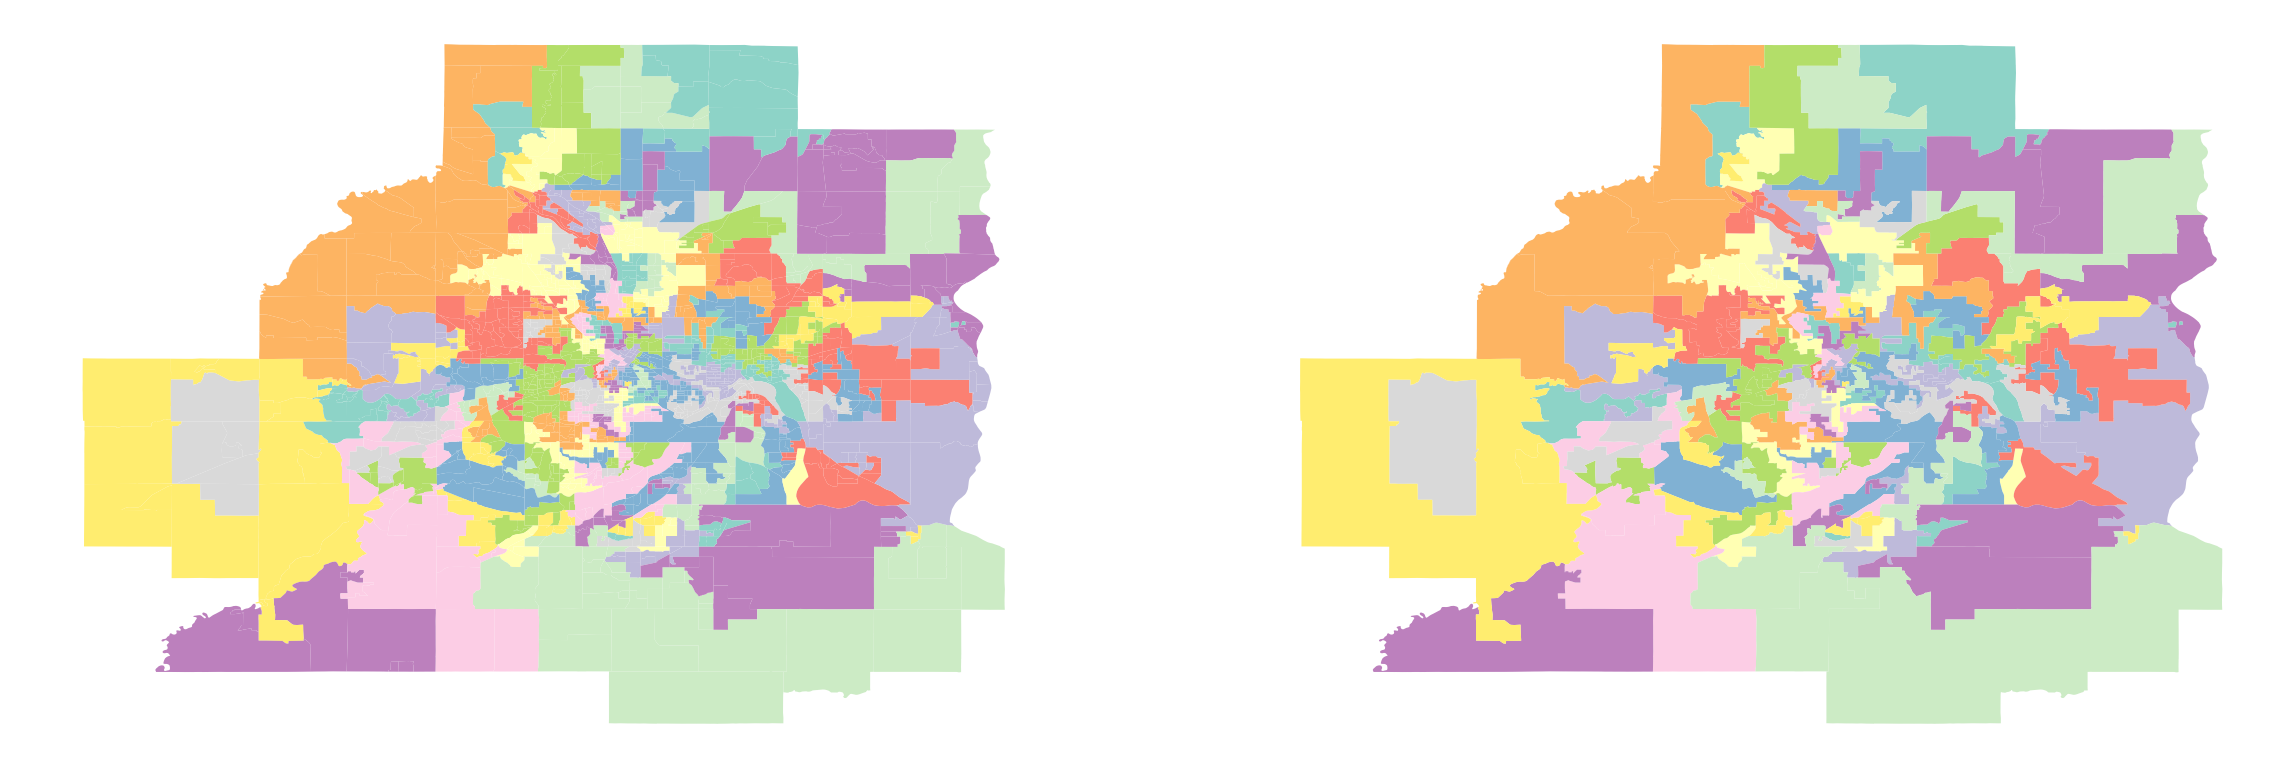

In [16]:
# We'll make a few side-by-side plots. This code wraps the setup into a function.
def two_plot_setup():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes

fig, axes = two_plot_setup()

# color tracts based on region ID
rids = copy.copy(results.region_ids)
shp_map['rids'] = rids
shp_map.plot('rids', categorical=True, alpha=1, colormap='Set3', axes=axes[0])

# disolve the tracts into regions
region_groups = shp_map.groupby('rids')
region_map = gp.GeoDataFrame(index=region_groups.indices.keys())
region_map['rids'] = region_groups.indices.keys()
region_map['geometry'] = region_groups.geometry.apply(shapely.ops.unary_union)
region_map.plot('rids', categorical=True,  colormap='Set3', axes=axes[1])

In [17]:
type(shp_map)

shp_map.to_file("output/metc7cnty_4var.shp")

geopandas.geodataframe.GeoDataFrame